# Generate Dataframe of Incident Status Information

pwd

In [1]:
cd ..

e:\two_stage_model\data_processing


In [2]:
import geopandas as gpd
import pandas as pd
import pickle
import datetime
import numpy as np
import glob
import os

from datetime import datetime as dt
from shapely.geometry import Point
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from bisect import bisect_left

In [3]:
country_name = 'TSMO'
model_path = 'E:/two_stage_model'
# Hyperparamter
# Time
start_date = dt(2022, 2, 14)
end_date =dt(2023, 2, 12)
start_time = 330 # 05:30:00 
end_time = 1260 # 21:00:00
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 260 business dates
datetime_index = pd.bdate_range(start=start_date, end=end_date+datetime.timedelta(days=1),freq="5min")
upstream_range_mile = 0.3 # keep same when calculate slowdown speed
minimum_abnormal_sd_length = 3 # every 5 min, meaning larger than 15 min regard as incident

In [4]:
busi_date[-26]

datetime.date(2023, 1, 6)

In [5]:
upstream_range_mile = float("{:.1f}".format(upstream_range_mile))

# 1. Merage Data into one csv file
### Attention! Only Excute this block if {country_name}_df_inc_raw.pkl is not in this folder

In [6]:
merged_inc_dfs = []

In [7]:
incident_files = glob.glob(f'{model_path}/data/{country_name}/incident_raw' + '/*.csv')

In [8]:
for file_path in incident_files:
    single_inc_df = pd.read_csv(file_path)
    merged_inc_dfs.append(single_inc_df)

In [9]:
merged_inc_df_raw = pd.concat(merged_inc_dfs, axis=0)

In [10]:
merged_inc_df_raw

Event ID      System Agency  \
0       WAZE_0184b74f-b75b-4450-b19a-114ab8fc0ff3        Waze   Waze   
1       WAZE_173d674d-471c-43ff-bf51-fe0ef4463a58        Waze   Waze   
2       WAZE_18631f68-0611-4896-8f84-a584e3adef19        Waze   Waze   
3       WAZE_20c103f0-b3d3-4252-adc8-0d838e9a02d3        Waze   Waze   
4       WAZE_240280b6-59e0-4942-b8b0-35f5bf41f9a1        Waze   Waze   
...                                           ...         ...    ...   
8503  MDOT_CHART_feffcba61a1408a60063d32ec4235c0a  MDOT CHART  MDDOT   
8504  MDOT_CHART_ff0025e0277e069e0063d32ec4235c0a  MDOT CHART  MDDOT   
8505  MDOT_CHART_ff002d966f630aaf0063d32ec4235c0a  MDOT CHART  MDDOT   
8506  MDOT_CHART_ff00332c202108a60063d32ec4235c0a  MDOT CHART  MDDOT   
8507  MDOT_CHART_ff00fa681538059a0063d32ec4235c0a  MDOT CHART  MDDOT   

     Standardized Type Agency-specific Type Agency-specific Sub Type  \
0            Collision             Accident           Accident Minor   
1            Collision             Accident           Accident Major   
2            Collision             Accident           Accident Minor   
3            Collision             Accident           Accident Minor   
4            Collision             Accident           Accident Minor   
...                ...                  ...                      ...   
8503  Disabled Vehicle     Disabled Vehicle                      NaN   
8504  Disabled Vehicle     Disabled Vehicle                      NaN   
8505         Collision             Incident                      NaN   
8506      Obstructions             Incident                      NaN   
8507  Disabled Vehicle             Incident                      NaN   

                     Start time                Closed time Open/Closed  \
0     2022-02-16T17:53:42-05:00  2022-02-16T18:05:02-05:00      Closed   
1     2022-02-16T07:42:38-05:00  2022-02-16T08:14:49-05:00      Closed   
2     2022-02-16T16:32:11-05:00  2022-02-16T17:19:57-05:00      Closed   
3     2022-02-16T08:15:36-05:00  2022-02-16T09:14:25-05:00      Closed   
4     2022-02-16T20:01:37-05:00  2022-02-16T20:34:34-05:00      Closed   
...                         ...                        ...         ...   
8503  2022-12-23T15:50:46-05:00  2022-12-23T16:11:24-05:00      Closed   
8504  2022-12-17T21:45:52-05:00  2022-12-17T22:01:59-05:00      Closed   
8505  2022-12-30T17:17:58-05:00  2022-12-30T18:08:51-05:00      Closed   
8506  2022-12-23T16:44:12-05:00  2022-12-23T16:44:23-05:00      Closed   
8507  2022-12-14T15:56:08-05:00  2022-12-14T16:21:33-05:00      Closed   

                                               Location  ...  Longitude  \
0                                                 I-695  ... -76.698454   
1                                                 MD-97  ... -76.996757   
2                                                 I-49B  ... -76.679234   
3                                                 I-695  ... -76.520340   
4                                           WATERLOO RD  ... -76.778175   
...                                                 ...  ...        ...   
8503     I-70 WEST AT EXIT 87A US 29 COLUMBIA PIKE (WB)  ... -76.817592   
8504            I-83 NORTH AT EXIT 16A TIMONIUM RD (NB)  ... -76.633392   
8505            I-83 NORTH AT EXIT 16A TIMONIUM RD (NB)  ... -76.633392   
8506  I-695 INNER LOOP PRIOR TO EXIT 44 MD 695 BROEN...  ... -76.508928   
8507  I-95 NORTH AT MP 54.8 (FORT MCHENRY TUNNEL) BO...  ... -76.575552   

             Road   Direction          County     State  \
0           I-695       North       Baltimore  Maryland   
1           MD 97       North         Carroll  Maryland   
2            I-49        West       Baltimore  Maryland   
3           I-695        West       Baltimore  Maryland   
4     WATERLOO RD         NaN          Howard  Maryland   
...           ...         ...             ...       ...   
8503         I-70        West          Howard  Maryland   
8504         I-83       North       Baltimore  Ma

In [11]:
print('Incident Type Includes', list(set(merged_inc_df_raw['Standardized Type'])))
print('Agency-specific Type Includes', list(set(merged_inc_df_raw['Agency-specific Type'])))
print('Agency-specific Sub Type Includes', list(set(merged_inc_df_raw['Agency-specific Sub Type'])))
print('Incident Source Includes', list(set(merged_inc_df_raw['System'])))
print('Column Includes', list(set(merged_inc_df_raw.columns)))
print('Country Includes', list(set(merged_inc_df_raw['County'])))

Incident Type Includes ['Disabled Vehicle', 'Collision', 'Flood', 'Emergency Roadwork', 'Weather Condition', 'Incident', 'Obstructions', 'Medical Emergency', 'Injuries Involved', 'Vehicle On Fire', 'Traffic Congestion']
Agency-specific Type Includes ['Accident', 'Disabled Vehicle', 'Incident', 'Congestion', 'Weatherhazard']
Agency-specific Sub Type Includes ['Accident Minor', nan, 'Hazard Weather Heavy Snow', 'Accident Major', 'Hazard Weather Flood']
Incident Source Includes ['MDOT CHART', 'Waze']
Column Includes ['Road', 'State', 'Start time', 'Direction', 'User Report Rating', 'County', 'Agency-specific Type', 'Open/Closed', 'Reliability Score', 'Max Lanes Closed', 'Confidence Score', 'Closed time', 'Op. Center', 'Event ID', 'Agency-specific Sub Type', 'Duration (Incident clearance time)', 'Location', 'Agency', 'Longitude', 'Latitude', 'Standardized Type', 'System']
Country Includes ['Howard', 'Baltimore', 'Baltimore City', 'Carroll']


In [12]:
pickle.dump(merged_inc_df_raw, open(f'{model_path}/data_processing/Incident_Manual_Check/{country_name}_df_inc_raw.pkl', "wb"))

# 2. Load Geo and Speed Information

 - load geo information

In [13]:
gdf_tmc_raw = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_tmc_raw = gdf_tmc_raw.rename(columns={"tmc":"id_tmc"})

In [14]:
print(list(set(gdf_tmc_raw['roadname'])))
print(list(set(gdf_tmc_raw['roadnumber'])))

['HAMMONDS FERRY RD', 'N HILTON ST', 'ROGERS AVE', 'FREDERICK RD', 'CEDAR LN', 'CLARKSVILLE PIKE', 'SYKESVILLE RD', 'CROSBY RD', 'S HILTON ST', 'GARRISON BLVD', 'N ATHOL AVE', 'S CATON AVE', 'OLD MONTGOMERY RD', 'N PROSPECT AVE', 'NEW CUT RD', 'SOUTHWESTERN BLVD', 'TWIN RIVERS RD', 'WOODLAWN DR', 'CENTRE PARK DR', 'BLOOMSBURY AVE', 'HILLTOP CIR', 'S BEECHFIELD AVE', 'UMBC BLVD', 'N FRANKLINTOWN RD', 'CLARKE BLVD', 'OLD COLUMBIA PIKE', 'WILKENS AVE', 'ST PAUL ST', 'ACADEMY RD', 'JOHNNYCAKE RD', 'MORRIS RD', 'SECURITY BLVD', 'N ROLLING RD', 'SULPHUR SPRING RD', 'EXECUTIVE PARK DR', 'WINDSOR MILL RD', 'EDMONDSON AVE/EDMONDSON RIDGE RD', 'MILFORD MILL RD', 'ST LUKES LN', 'FREDERICK AVE', 'GWYNN OAK AVE', 'THISTLE RD', 'HOMESPUN DR', 'ST AGNES LN', 'WASHINGTON BLVD', 'OLD FREDERICK RD', 'ROBERT FULTON DR', 'COLUMBIA GATEWAY DR', 'EDMONDSON AVE', 'THUNDER HILL RD', 'OLD ANNAPOLIS RD', 'S ATHOL AVE', 'LONG GATE PKY', 'LITTLE PATUXENT PKY', 'W PATAPSCO AVE', 'METROPOLITAN BLVD', 'FREDERICK RD/

In [15]:
list(gdf_tmc_raw[gdf_tmc_raw['roadnumber']=='I-70']['id_tmc'])

['110P04479',
 '110+04480',
 '110P04480',
 '110+04481',
 '110P04481',
 '110+04482',
 '110P04482',
 '110+04483',
 '110P04483',
 '110+04484',
 '110P04484',
 '110+04485',
 '110P04485',
 '110+04486',
 '110P04486',
 '110N04486',
 '110-04485',
 '110N04485',
 '110-04484',
 '110N04484',
 '110-04483',
 '110N04483',
 '110-04482',
 '110N04482',
 '110-04481',
 '110N04481',
 '110-04480',
 '110N04480',
 '110-04479',
 '110N04479']

 - load upstream k mile dict

In [16]:
upstream_k_mile_dict =  pickle.load(open(f"{model_path}/data/{country_name}/processed_data/upstream_rage_dict/{country_name}_upstream_{upstream_range_mile}_mile.pkl", "rb"))

 - load dict_prev_tmc

In [17]:
dict_prev_tmc = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_dict_prev_tmc.pkl", "rb"))

 - load speed information

In [18]:
spd_record_all = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_from_1_min.pkl", "rb"))

In [19]:
speed_available_tmc_list = list(spd_record_all.columns)

 - load slowdown speed

In [20]:
df_slowdown_speed = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_slowdown_speed.pkl", "rb"))

# 3 Select TMC segement for analysis

 - get selected TMC segement list
 - Currently, we adopt the rule that selects the link where all speed data (all, pv, truck) are available, so that it depends on 0_Generate_Speed.ipynb

In [21]:
spd_record_selected = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_selected.pkl", "rb"))
selected_tmc_list = list(spd_record_selected.columns)

In [22]:
gdf_tmc_selected = gdf_tmc_raw[gdf_tmc_raw['id_tmc'].isin(selected_tmc_list)]

In [23]:
gdf_tmc_selected_polygon = gdf_tmc_selected.copy()
gdf_tmc_selected_polygon["geometry"] = gdf_tmc_selected.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)

# 4 Process Incident Dataframe
 - load incident information

In [24]:
merged_inc_df_raw = pickle.load(open(f"{model_path}/data_processing/Incident_Manual_Check/{country_name}_df_inc_raw.pkl", "rb")) 

## 4.1 Clean Date and Time

In [25]:
merged_inc_df_raw = merged_inc_df_raw[~((merged_inc_df_raw["Closed time"].isna()) & (merged_inc_df_raw["Duration (Incident clearance time)"].isna()))] 

In [26]:
merged_inc_df_raw["dt_start"] = merged_inc_df_raw.apply(lambda x: dt.strptime(x["Start time"][:-6], '%Y-%m-%dT%H:%M:%S'), axis=1)
merged_inc_df_raw["dt_end"] = merged_inc_df_raw.apply(lambda x: dt.strptime(x["Closed time"][:-6], '%Y-%m-%dT%H:%M:%S'), axis=1)
merged_inc_df_raw["dt_duration"] = merged_inc_df_raw["dt_end"] - merged_inc_df_raw["dt_start"]

## 4.2 Perform spatial join to map incident location to TMC segment(s)

In [27]:
# Note: gpd.GeoDataFrame() is inplace, so I supply TSMO_df_inc_raw.copy() here
gdf_inc_point = gpd.GeoDataFrame(
                    merged_inc_df_raw.copy(), crs={'init': 'epsg:4326'},
                    geometry=[Point(xy) for xy in zip(merged_inc_df_raw["Longitude"], merged_inc_df_raw["Latitude"])]) # (163140, 34)

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [28]:
gdf_inc_point = gdf_inc_point[~((gdf_inc_point.Latitude.isna()) | (gdf_inc_point.Longitude.isna()))] # (163139, 34)

<Axes: >

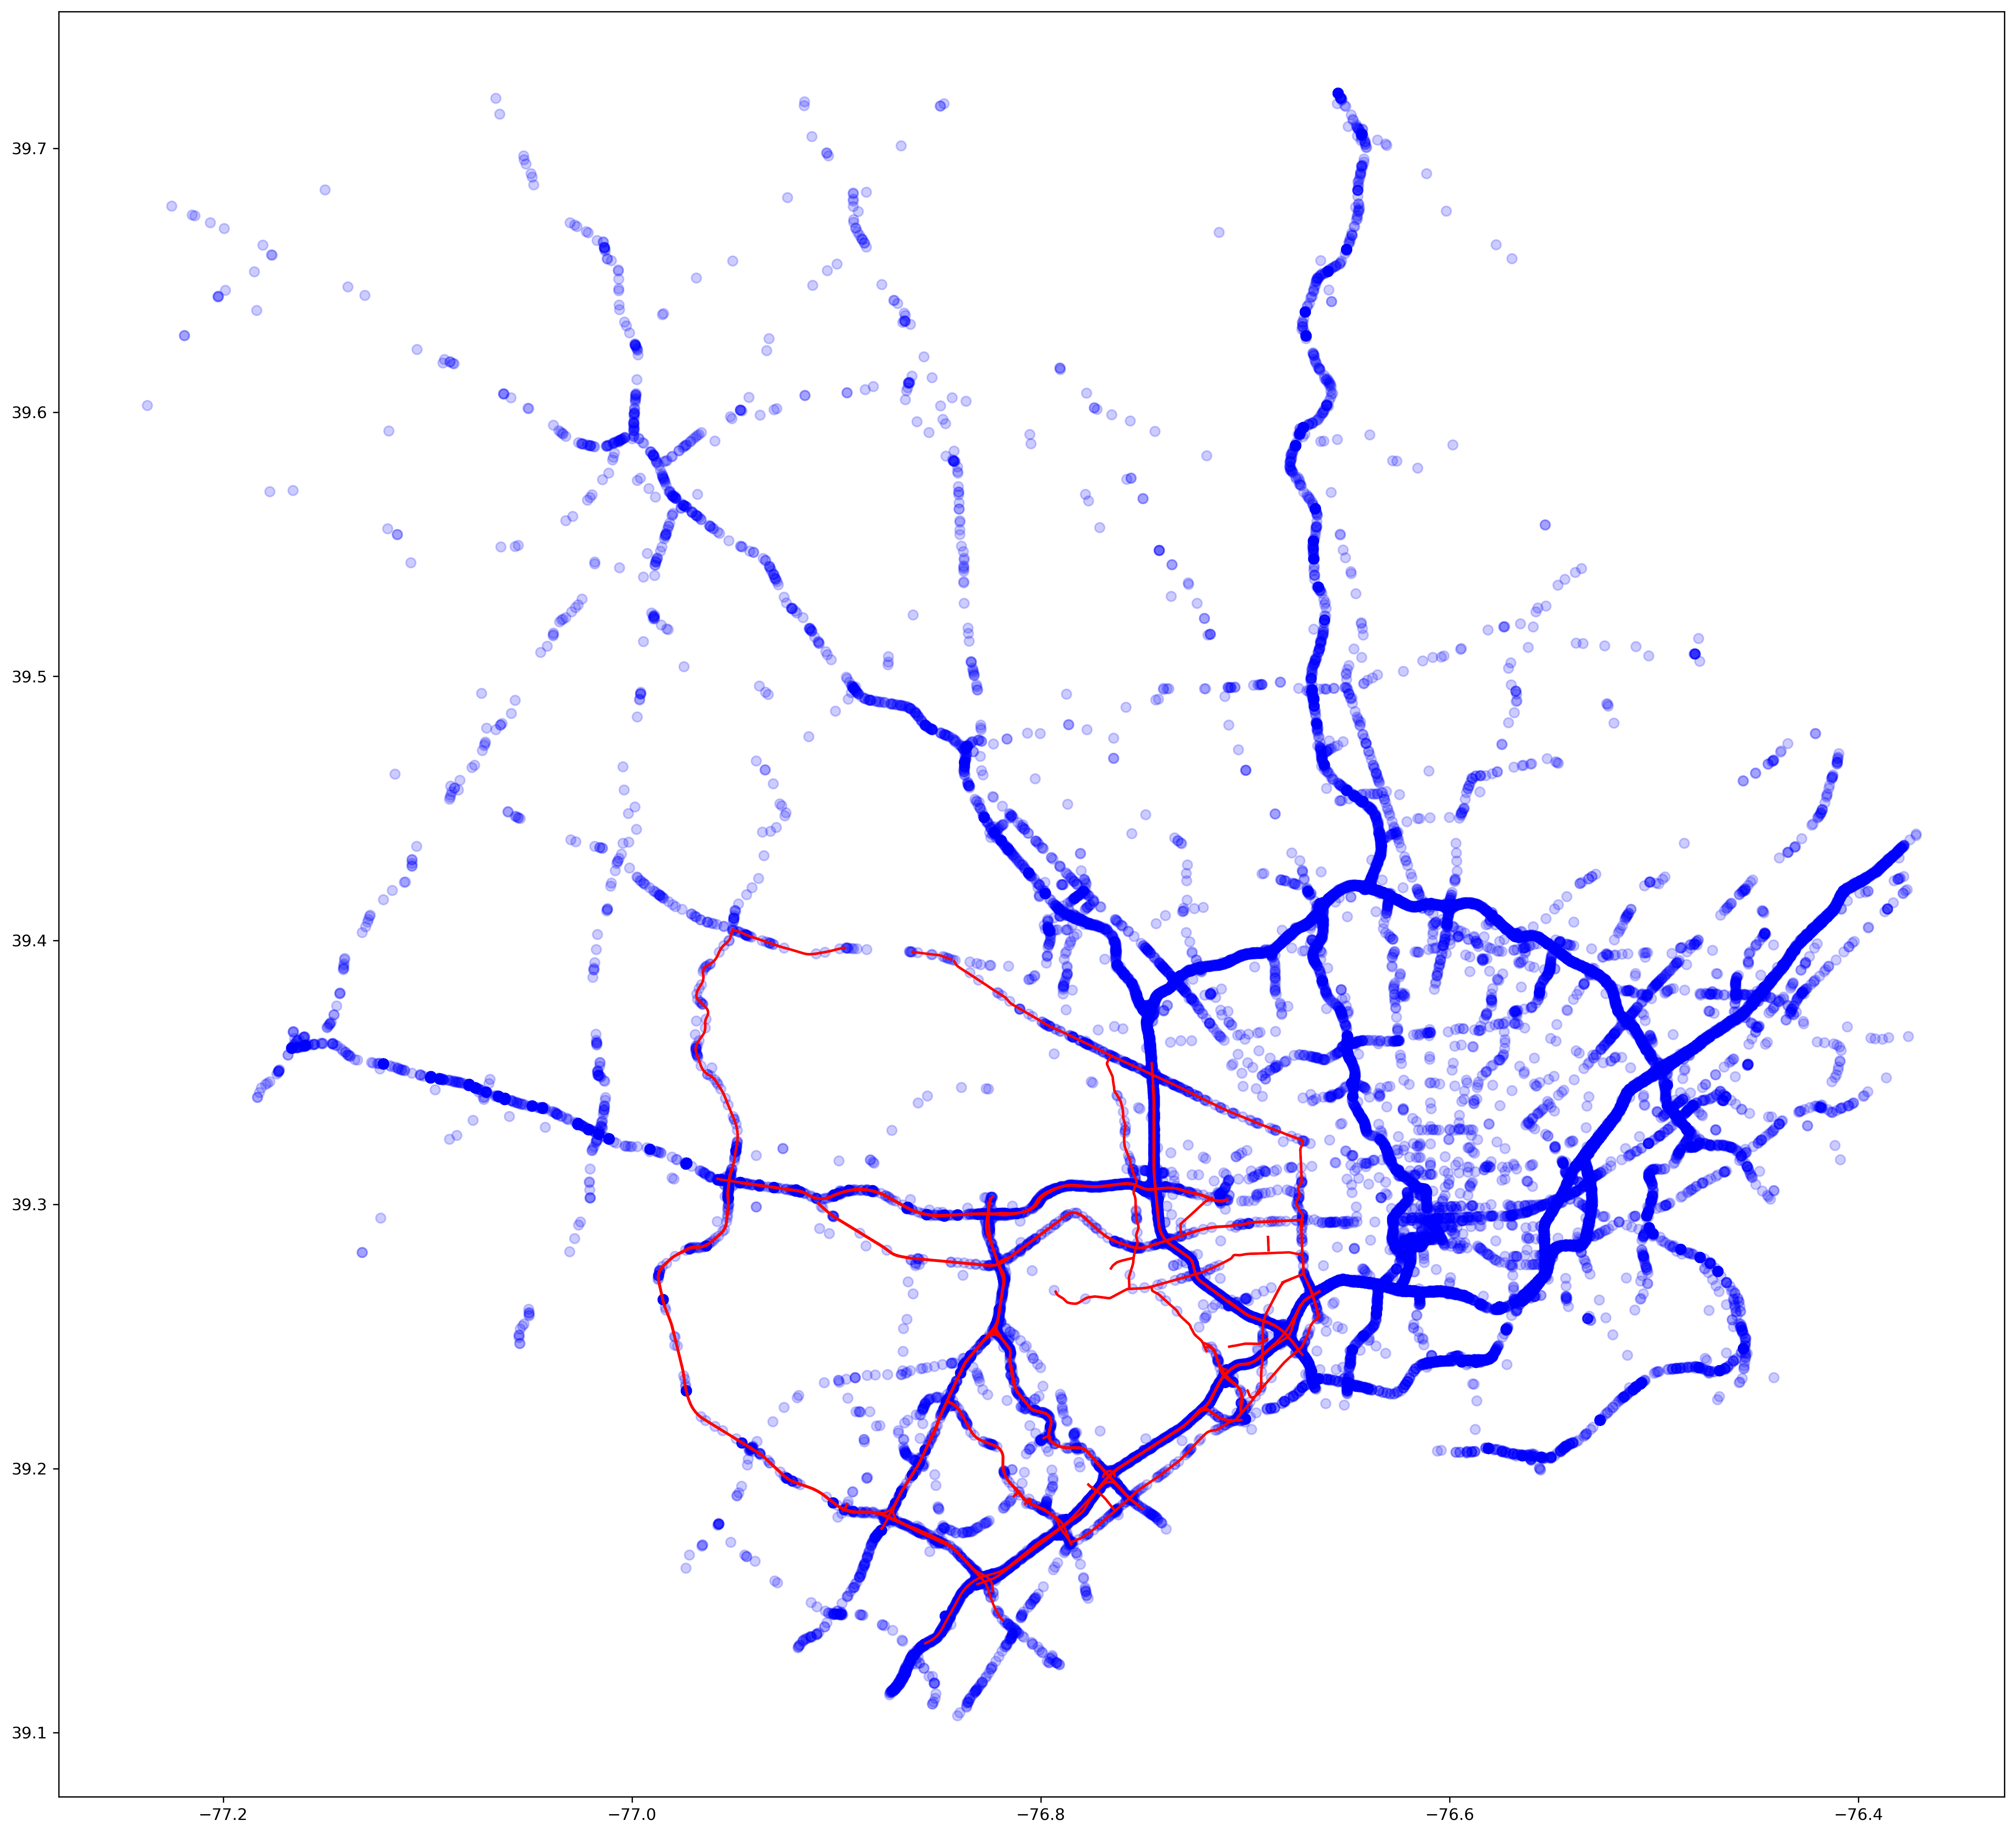

In [29]:
# Visualize Incident Location Points of All Time from Feb 14, 2022 to Feb 12, 2023
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_inc_point.plot(ax=ax, color="blue", alpha=0.2)
gdf_tmc_selected.plot(ax=ax, color = "red")

In [30]:
gdf_inc_point_matched_with_tmc = gpd.sjoin(left_df=gdf_inc_point, right_df= gdf_tmc_selected_polygon, how="left", op="within")  

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\haowu\AppData\Local\Temp\ipykernel_536732\1651549596.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  gdf_inc_point_matched_with_tmc = gpd.sjoin(left_df=gdf_inc_point, right_df= gdf_tmc_selected_polygon, how="left", op="within")


In [31]:
gdf_inc_record_all = gdf_inc_point_matched_with_tmc[~gdf_inc_point_matched_with_tmc.id_tmc.isna()]  

In [33]:
pickle.dump(gdf_inc_record_all, open(f"./Incident_Manual_Check/{country_name}_gdf_inc_record_all.pkl", "wb"))

In [34]:
gdf_inc_record_all

Event ID      System Agency  \
0       WAZE_0184b74f-b75b-4450-b19a-114ab8fc0ff3        Waze   Waze   
34      WAZE_f3fedafb-90fe-4bb3-ae1f-4be12e5189f7        Waze   Waze   
36      WAZE_fe9aa813-59ea-4b27-8e3c-16ab44d2fd44        Waze   Waze   
36      WAZE_fe9aa813-59ea-4b27-8e3c-16ab44d2fd44        Waze   Waze   
39      WAZE_03d89551-44c2-4a9d-a161-05282bd75e12        Waze   Waze   
...                                           ...         ...    ...   
8470  MDOT_CHART_f90026620918059a0063d32ec4235c0a  MDOT CHART  MDDOT   
8473  MDOT_CHART_f9fe81cf94be06a00063d32ec4235c0a  MDOT CHART  MDDOT   
8479  MDOT_CHART_faff53962993069e0063d32ec4235c0a  MDOT CHART  MDDOT   
8480  MDOT_CHART_faff88c0f56a059d0063d32ec4235c0a  MDOT CHART  MDDOT   
8503  MDOT_CHART_feffcba61a1408a60063d32ec4235c0a  MDOT CHART  MDDOT   

     Standardized Type Agency-specific Type Agency-specific Sub Type  \
0            Collision             Accident           Accident Minor   
34           Collision             Accident           Accident Major   
36           Collision             Accident           Accident Major   
36           Collision             Accident           Accident Major   
39           Collision             Accident           Accident Minor   
...                ...                  ...                      ...   
8470   Vehicle On Fire             Incident                      NaN   
8473  Disabled Vehicle     Disabled Vehicle                      NaN   
8479  Disabled Vehicle     Disabled Vehicle                      NaN   
8480         Collision             Incident                      NaN   
8503  Disabled Vehicle     Disabled Vehicle                      NaN   

                     Start time                Closed time Open/Closed  \
0     2022-02-16T17:53:42-05:00  2022-02-16T18:05:02-05:00      Closed   
34    2022-02-16T12:37:18-05:00  2022-02-16T13:10:50-05:00      Closed   
36    2022-02-16T15:47:53-05:00  2022-02-16T16:36:45-05:00      Closed   
36    2022-02-16T15:47:53-05:00  2022-02-16T16:36:45-05:00      Closed   
39    2022-02-15T16:19:47-05:00  2022-02-15T16:36:24-05:00      Closed   
...                         ...                        ...         ...   
8470  2022-12-14T13:39:30-05:00  2022-12-14T13:59:05-05:00      Closed   
8473  2022-12-19T14:43:11-05:00  2022-12-19T14:45:22-05:00      Closed   
8479  2022-12-17T23:14:14-05:00  2022-12-17T23:16:22-05:00      Closed   
8480  2022-12-17T02:07:44-05:00  2022-12-17T04:18:19-05:00      Closed   
8503  2022-12-23T15:50:46-05:00  2022-12-23T16:11:24-05:00      Closed   

                                               Location  ... roadnumber  \
0                                                 I-695  ...      I-695   
34                                                I-695  ...      I-695   
36                                           LIBERTY RD  ...      MD-26   
36                                           LIBERTY RD  ...      MD-26   
39                                                US-29  ...      US-29   
...                                                 ...  ...        ...   
8470  I-95 SOUTH AT EXIT 35B MD 216 SCAGGSVILLE RD (SB)  ...       I-95   
8473                         I-70 at Patapsco River Br.  ...       I-70   
8479    I-95 SOUTH PRIOR TO EXIT 43A MD 100 MD 100 (SB)  ...       I-95   
8480    I-95 SOUTH AT EXIT 49A I 695 BALTO BELTWAY (SB)  ...       I-95   
8503     I-70 WEST AT EXIT 87A US 29 COLUMBIA PIKE (WB)  ...       I-70   

         county  state    zip start_latitude start_longitude end_latitude  \
0     BALTIMORE     MD  21227       39.25730       -76.69578     39.26047   
34    BALTIMORE     MD  21228       39.28854       -76.74088     39.28431   
36    BALTIMORE     MD  21133       39.38127       -76.82317     39.36911   
36    BALTIMORE     MD  21133       39.36911       -76.79927     39.38127   
39       HOWARD     MD  21044       39.18547       -76.87178     39.19761   
...         ...    ...    ...            ...             ..

## 4.3. Finalize Spatial-temporal Dataframe of Incident Status
-Make spatial-temporal dataframe of incident status

In [35]:
gdf_inc_record_all = pickle.load(open(f"./Incident_Manual_Check/{country_name}_gdf_inc_record_all.pkl", "rb"))

In [36]:
# Make sure start and/or end date falls into business dates
gdf_inc_record_all_filtered_date = gdf_inc_record_all[
    (gdf_inc_record_all.dt_start.dt.date.isin(busi_date)) | (gdf_inc_record_all.dt_end.dt.date.isin(busi_date))
    ]  # (29800, 52)


# Make sure start and/or end time falls into business hours
gdf_inc_record_all_filtered_date_time = gdf_inc_record_all_filtered_date[
                ((gdf_inc_record_all_filtered_date.dt_start.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_start.dt.minute >= start_time) & (gdf_inc_record_all_filtered_date.dt_start.dt.hour*60 +gdf_inc_record_all_filtered_date.dt_start.dt.minute < end_time)) |
                ((gdf_inc_record_all_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_end.dt.minute >= start_time) & (gdf_inc_record_all_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_end.dt.minute < end_time)) 
            ]  # (26984, 52)

In [37]:
gdf_inc_record_all_filtered_date_time = gdf_inc_record_all_filtered_date_time[gdf_inc_record_all_filtered_date_time.dt_start.dt.date == gdf_inc_record_all_filtered_date_time.dt_end.dt.date]

In [38]:
gdf_inc_record_all_filtered_date_time

Event ID      System Agency  \
0       WAZE_0184b74f-b75b-4450-b19a-114ab8fc0ff3        Waze   Waze   
34      WAZE_f3fedafb-90fe-4bb3-ae1f-4be12e5189f7        Waze   Waze   
36      WAZE_fe9aa813-59ea-4b27-8e3c-16ab44d2fd44        Waze   Waze   
36      WAZE_fe9aa813-59ea-4b27-8e3c-16ab44d2fd44        Waze   Waze   
39      WAZE_03d89551-44c2-4a9d-a161-05282bd75e12        Waze   Waze   
...                                           ...         ...    ...   
8459  MDOT_CHART_f6ffe09f040f09aa0063d32ec4235c0a  MDOT CHART  MDDOT   
8459  MDOT_CHART_f6ffe09f040f09aa0063d32ec4235c0a  MDOT CHART  MDDOT   
8470  MDOT_CHART_f90026620918059a0063d32ec4235c0a  MDOT CHART  MDDOT   
8473  MDOT_CHART_f9fe81cf94be06a00063d32ec4235c0a  MDOT CHART  MDDOT   
8503  MDOT_CHART_feffcba61a1408a60063d32ec4235c0a  MDOT CHART  MDDOT   

     Standardized Type Agency-specific Type Agency-specific Sub Type  \
0            Collision             Accident           Accident Minor   
34           Collision             Accident           Accident Major   
36           Collision             Accident           Accident Major   
36           Collision             Accident           Accident Major   
39           Collision             Accident           Accident Minor   
...                ...                  ...                      ...   
8459      Obstructions             Incident                      NaN   
8459      Obstructions             Incident                      NaN   
8470   Vehicle On Fire             Incident                      NaN   
8473  Disabled Vehicle     Disabled Vehicle                      NaN   
8503  Disabled Vehicle     Disabled Vehicle                      NaN   

                     Start time                Closed time Open/Closed  \
0     2022-02-16T17:53:42-05:00  2022-02-16T18:05:02-05:00      Closed   
34    2022-02-16T12:37:18-05:00  2022-02-16T13:10:50-05:00      Closed   
36    2022-02-16T15:47:53-05:00  2022-02-16T16:36:45-05:00      Closed   
36    2022-02-16T15:47:53-05:00  2022-02-16T16:36:45-05:00      Closed   
39    2022-02-15T16:19:47-05:00  2022-02-15T16:36:24-05:00      Closed   
...                         ...                        ...         ...   
8459  2022-12-26T16:18:23-05:00  2022-12-26T16:25:21-05:00      Closed   
8459  2022-12-26T16:18:23-05:00  2022-12-26T16:25:21-05:00      Closed   
8470  2022-12-14T13:39:30-05:00  2022-12-14T13:59:05-05:00      Closed   
8473  2022-12-19T14:43:11-05:00  2022-12-19T14:45:22-05:00      Closed   
8503  2022-12-23T15:50:46-05:00  2022-12-23T16:11:24-05:00      Closed   

                                               Location  ... roadnumber  \
0                                                 I-695  ...      I-695   
34                                                I-695  ...      I-695   
36                                           LIBERTY RD  ...      MD-26   
36                                           LIBERTY RD  ...      MD-26   
39                                                US-29  ...      US-29   
...                                                 ...  ...        ...   
8459  I-695 INNER LOOP AT EXIT 18A MD 26 LIBERTY RD ...  ...      I-695   
8459  I-695 INNER LOOP AT EXIT 18A MD 26 LIBERTY RD ...  ...      I-695   
8470  I-95 SOUTH AT EXIT 35B MD 216 SCAGGSVILLE RD (SB)  ...       I-95   
8473                         I-70 at Patapsco River Br.  ...       I-70   
8503     I-70 WEST AT EXIT 87A US 29 COLUMBIA PIKE (WB)  ...       I-70   

         county  state    zip start_latitude start_longitude end_latitude  \
0     BALTIMORE     MD  21227       39.25730       -76.69578     39.26047   
34    BALTIMORE     MD  21228       39.28854       -76.74088     39.28431   
36    BALTIMORE     MD  21133       39.38127       -76.82317     39.36911   
36    BALTIMORE     MD  21133       39.36911       -76.79927     39.38127   
39       HOWARD     MD  21044       39.18547       -76.87178     39.19761   
...         ...    ...    ...            ...             ..

In [39]:
tmc_frame = gdf_inc_record_all_filtered_date_time[gdf_inc_record_all_filtered_date_time['id_tmc']=='110+04483']
tmc_frame

Event ID      System Agency  \
58      WAZE_8573fdd0-3e41-4d6a-85f9-cf3337c126fd        Waze   Waze   
706     WAZE_283bef57-f6fa-4dea-86df-6f0437d2d86d        Waze   Waze   
858     WAZE_7d8e8156-d9d8-4125-aa58-cd30c7f58e15        Waze   Waze   
2225  MDOT_CHART_8a01542a50f701140062d32ec4235c0a  MDOT CHART  MDDOT   
3017  MDOT_CHART_4f00f1b2288a03470062d32ec4235c0a  MDOT CHART  MDDOT   
...                                           ...         ...    ...   
3864    WAZE_d09408dd-8eb4-4537-bdae-275a81abde7b        Waze   Waze   
4966  MDOT_CHART_ed00d025e17d04e50063d32ec4235c0a  MDOT CHART  MDDOT   
7917  MDOT_CHART_930076e9e3ff059c0063d32ec4235c0a  MDOT CHART  MDDOT   
7957  MDOT_CHART_99014a236e6706a00063d32ec4235c0a  MDOT CHART  MDDOT   
8119  MDOT_CHART_b900b8584ef20aae0063d32ec4235c0a  MDOT CHART  MDDOT   

     Standardized Type Agency-specific Type Agency-specific Sub Type  \
58           Collision             Accident           Accident Major   
706          Collision             Accident           Accident Minor   
858          Collision             Accident           Accident Minor   
2225  Disabled Vehicle     Disabled Vehicle                      NaN   
3017      Obstructions             Incident                      NaN   
...                ...                  ...                      ...   
3864         Collision             Accident           Accident Minor   
4966         Collision             Incident                      NaN   
7917         Collision             Incident                      NaN   
7957  Disabled Vehicle     Disabled Vehicle                      NaN   
8119  Disabled Vehicle     Disabled Vehicle                      NaN   

                     Start time                Closed time Open/Closed  \
58    2022-02-15T12:29:45-05:00  2022-02-15T12:37:42-05:00      Closed   
706   2022-03-04T13:50:53-05:00  2022-03-04T14:10:36-05:00      Closed   
858   2022-03-10T06:45:18-05:00  2022-03-10T07:49:59-05:00      Closed   
2225  2022-02-22T09:46:02-05:00  2022-02-22T09:48:28-05:00      Closed   
3017  2022-04-01T19:28:50-04:00  2022-04-01T19:54:40-04:00      Closed   
...                         ...                        ...         ...   
3864  2023-02-09T17:58:11-05:00  2023-02-09T18:19:50-05:00      Closed   
4966  2023-02-09T18:09:25-05:00  2023-02-09T18:47:47-05:00      Closed   
7917  2022-12-16T18:31:53-05:00  2022-12-16T19:29:58-05:00      Closed   
7957  2022-12-19T08:29:07-05:00  2022-12-19T08:42:47-05:00      Closed   
8119  2022-12-30T09:14:48-05:00  2022-12-30T09:59:24-05:00      Closed   

                                               Location  ... roadnumber  \
58                                                 I-70  ...       I-70   
706                                                I-70  ...       I-70   
858                                                I-70  ...       I-70   
2225                         I-70 at Patapsco River Br.  ...       I-70   
3017                               I-70 WEST PAST I-695  ...       I-70   
...                                                 ...  ...        ...   
3864                                               I-70  ...       I-70   
4966   I-70 WEST PAST EXIT 91B I 695 BALTO BELTWAY (WB)  ...       I-70   
7917                               I-70 WEST AT MM 91.0  ...       I-70   
7957                  I-70 WEST PRIOR TO EXIT 87A US 29  ...       I-70   
8119  I-70 EAST PRIOR TO EXIT 91A I 695 BALTO BELTWA...  ...       I-70   

         county  state    zip start_latitude start_longitude end_latitude  \
58    BALTIMORE     MD  21043       39.30761       -76.75416     39.29666   
706   BALTIMORE     MD  21043       39.30761       -76.75416     39.29666   
858   BALTIMORE     MD  21043       39.30761       -76.75416     39.29666   
2225  BALTIMORE     MD  21043       39.30761       -76.75416     39.29666   
3017  BALTIMORE     MD  21043       39.30761       -76.75416     39.29666   
...         ...    ...    ...            ...             ..

In [43]:
tmc_frame['Start_t'] = pd.to_datetime(tmc_frame['Start time'], utc=True)

# Then, select the rows where the year is 2023 and the month is January or February
filtered_df = tmc_frame[(tmc_frame['Start_t'].dt.year == 2023) & (tmc_frame['Start_t'].dt.month.isin([1, 2]))]

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [44]:
filtered_df

Event ID      System Agency  \
1526    WAZE_4f7e7c9c-a9b3-43b0-82ab-5c71fdbd3aa7        Waze   Waze   
1795    WAZE_f8df68e4-7034-4803-a27c-faf3036e85ad        Waze   Waze   
2182    WAZE_0a682d04-c420-4a9e-be62-392017d8f4bd        Waze   Waze   
2264    WAZE_3ef10596-67ff-4b09-866e-283937d63cd4        Waze   Waze   
2293    WAZE_87946547-8f9f-4628-bd37-1eb20e46c373        Waze   Waze   
2376    WAZE_8f2301a4-e83d-4774-8c50-4866e1273247        Waze   Waze   
2809    WAZE_107a9e0b-3bca-4741-842a-96f60c6fd6fd        Waze   Waze   
2846    WAZE_80cb9a15-04a5-48a5-9217-7a679c588312        Waze   Waze   
2854    WAZE_93547f6f-1484-4007-a783-8f7fc625a32a        Waze   Waze   
2859    WAZE_af6a682f-c6af-4862-a151-e3fc0b87facf        Waze   Waze   
3184    WAZE_c8b12a6f-8420-4a7c-89cc-0fddc3991396        Waze   Waze   
3540    WAZE_0e174e98-e1bc-49a4-a116-018f85d0af8a        Waze   Waze   
3553    WAZE_548951d2-c302-4739-bbe3-1fd51fc40bf5        Waze   Waze   
3610    WAZE_36b50790-defa-4eab-b6f5-cd86d1085267        Waze   Waze   
3621    WAZE_505d55d2-af12-493c-8ec3-ca41f7e16c21        Waze   Waze   
3647    WAZE_94b9a129-7445-4368-b2b7-72068ccffc47        Waze   Waze   
4421  MDOT_CHART_66017fcf790604e40063d32ec4235c0a  MDOT CHART  MDDOT   
4645  MDOT_CHART_9900403894f903e00063d32ec4235c0a  MDOT CHART  MDDOT   
4983  MDOT_CHART_f2000e4cef1902dd0063d32ec4235c0a  MDOT CHART  MDDOT   

      Standardized Type Agency-specific Type Agency-specific Sub Type  \
1526          Collision             Accident           Accident Minor   
1795          Collision             Accident           Accident Minor   
2182          Collision             Accident           Accident Minor   
2264          Collision             Accident           Accident Minor   
2293          Collision             Accident           Accident Minor   
2376          Collision             Accident           Accident Minor   
2809          Collision             Accident           Accident Major   
2846          Collision             Accident           Accident Minor   
2854          Collision             Accident           Accident Minor   
2859          Collision             Accident           Accident Minor   
3184          Collision             Accident           Accident Minor   
3540          Collision             Accident           Accident Major   
3553          Collision             Accident           Accident Major   
3610          Collision             Accident           Accident Major   
3621          Collision             Accident           Accident Minor   
3647          Collision             Accident           Accident Major   
4421  Injuries Involved             Incident                      NaN   
4645  Injuries Involved             Incident                      NaN   
4983   Disabled Vehicle     Disabled Vehicle                      NaN   

                     Start time                Closed time Open/Closed  \
1526  2023-01-03T17:43:26-05:00  2023-01-03T17:52:50-05:00      Closed   
1795  2023-01-11T17:44:19-05:00  2023-01-11T18:15:50-05:00      Closed   
2182  2023-01-16T09:30:49-05:00  2023-01-16T09:36:48-05:00      Closed   
2264  2023-01-18T16:07:24-05:00  2023-01-18T16:12:51-05:00      Closed   
2293  2023-01-18T15:50:30-05:00  2023-01-18T16:00:48-05:00      Closed   
2376  2023-01-17T14:25:03-05:00  2023-01-17T15:03:47-05:00      Closed   
2809  2023-01-25T19:23:16-05:00  2023-01-25T20:13:46-05:00      Closed   
2846  2023-01-25T15:36:13-05:00  2023-01-25T16:17:49-05:00      Closed   
2854  2023-01-25T15:37:20-05:00  2023-01-25T15:58:50-05:00      Closed   
2859  2023-01-25T18:51:27-05:00  2023-01-25T19:11:49-05:00      Closed   
3184  2023-01-30T06:31:31-05:00  2023-01-30T07:02:46-05:00      Closed   
3540  2023-02-06T07:41:34-05:00  2023-02-06T08:51:48-05:00      Closed   
3553  2023-02-06T08:10:30-05:00  2023-02-06T08:18:51-05:00      Closed   
3610  2023-02-08T16:08:55-05:00  2023-02-08T17:24:52-05:00      Closed   
3621  2023-02-08T17:51:30-05:

In [45]:
df_inc = pd.DataFrame(data=0.0,index=datetime_index,columns=list(set(gdf_tmc_raw.id_tmc))) 

In [46]:
df_inc = df_inc[
        (pd.to_datetime(df_inc.index.date).isin(busi_date)) &   # be careful about the syntax here, dealing with index filtering is really annoying
        (df_inc.index.hour*60 + df_inc.index.minute >= start_time) &
        (df_inc.index.hour*60 + df_inc.index.minute < end_time) 
    ] 

In [47]:
df_inc

110P11784  110-04383  110P55491  110P54580  110P54678  \
2022-02-14 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2023-02-10 20:35:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     110N52812  110N52849  110P54698  110P12383  110N52828  \
2022-02-14 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2023-02-10 20:35:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     ...  110P55265  110+18370  110N05225  110N05035  \
2022-02-14 05:30:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00  ...        0.0        0.0        0.0        0.0   
...                  ...        ...        ...        ...        ...   
2023-02-10 20:35:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00  ...        0.0        0.0        0.0        0.0   

                     110N04419  110-12709  110P09565  110N09724  110N12369  \
2022-02-14 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2023-02-10 20:35:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     110P52849  
2022-02-14 05:30:00        0.0  
2022-02-14 05:35:00        0.0  
2022-02-14 05:40:00        0.0  
2022-02-14 05:45:00        0.0  
2022-02-14 05:50:00        0.0  
...                        ...  
2023-02-10 20:35:00        0.0  
2023-02-10 20:40:00        0.0  
2023-02-10 20:45:00        0.0  
2023-02-10 20:5

In [48]:
def earliest_time_for_date(index, date_str):
    filtered_times = index[index.date == pd.Timestamp(date_str).date()]
    return filtered_times.min()

In [49]:
def find_earlier_time(time_list, query_time):
    position = bisect_left(time_list, query_time)
    if time_list[position-1].date()!=query_time.date():
        return earliest_time_for_date(time_list, query_time.date()) if position < len(time_list) else None
    else:
        return time_list[position-1] # if position else None

In [50]:
def latest_time_for_date(index, date_str):
    filtered_times = index[index.date == pd.Timestamp(date_str).date()]
    return filtered_times.max()

In [51]:
def find_later_time(time_list, query_time):
    position = bisect_left(time_list, query_time)
    if position < len(time_list):
        if time_list[position].date()!=query_time.date():
            return latest_time_for_date(time_list, query_time.date()) if position < len(time_list) else None
        else:
            return time_list[position]  
    else:
        return max(time_list)

### 4.3.1 Check if there is any incident whose assigned start date and end date are different

In [52]:
for i in tqdm(range(len(gdf_inc_record_all_filtered_date_time))):
    start = gdf_inc_record_all_filtered_date_time.iloc[i].dt_start
    end = gdf_inc_record_all_filtered_date_time.iloc[i].dt_end
    id_tmc = gdf_inc_record_all_filtered_date_time.iloc[i].id_tmc

    # print(find_later_time(df_inc.index, end), end)
    if find_earlier_time(df_inc.index, start).date() != start.date() or find_later_time(df_inc.index, end).date() != end.date() or find_later_time(df_inc.index, end).date() != find_earlier_time(df_inc.index, start).date():
        print(gdf_inc_record_all_filtered_date_time.iloc[i])

100%|██████████| 7995/7995 [00:08<00:00, 963.30it/s] 


In [53]:
for i in tqdm(range(len(gdf_inc_record_all_filtered_date_time))):
    start = gdf_inc_record_all_filtered_date_time.iloc[i].dt_start
    end = gdf_inc_record_all_filtered_date_time.iloc[i].dt_end
    id_tmc = gdf_inc_record_all_filtered_date_time.iloc[i].id_tmc
    # df_inc_waze[(df_inc_waze.index >= start) & (df_inc_waze.index < end)][id_tmc] = 1.0 # this won't work as it will return a view instead of changing value in place
    df_inc.loc[find_earlier_time(df_inc.index, start): find_later_time(df_inc.index, end), id_tmc] = 1.0

100%|██████████| 7995/7995 [00:05<00:00, 1343.03it/s]


In [54]:
df_inc

110P11784  110-04383  110P55491  110P54580  110P54678  \
2022-02-14 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2023-02-10 20:35:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     110N52812  110N52849  110P54698  110P12383  110N52828  \
2022-02-14 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2023-02-10 20:35:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     ...  110P55265  110+18370  110N05225  110N05035  \
2022-02-14 05:30:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00  ...        0.0        0.0        0.0        0.0   
...                  ...        ...        ...        ...        ...   
2023-02-10 20:35:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00  ...        0.0        0.0        0.0        0.0   

                     110N04419  110-12709  110P09565  110N09724  110N12369  \
2022-02-14 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2023-02-10 20:35:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     110P52849  
2022-02-14 05:30:00        0.0  
2022-02-14 05:35:00        0.0  
2022-02-14 05:40:00        0.0  
2022-02-14 05:45:00        0.0  
2022-02-14 05:50:00        0.0  
...                        ...  
2023-02-10 20:35:00        0.0  
2023-02-10 20:40:00        0.0  
2023-02-10 20:45:00        0.0  
2023-02-10 20:5

In [55]:
np.count_nonzero(df_inc)

67242

<Axes: >

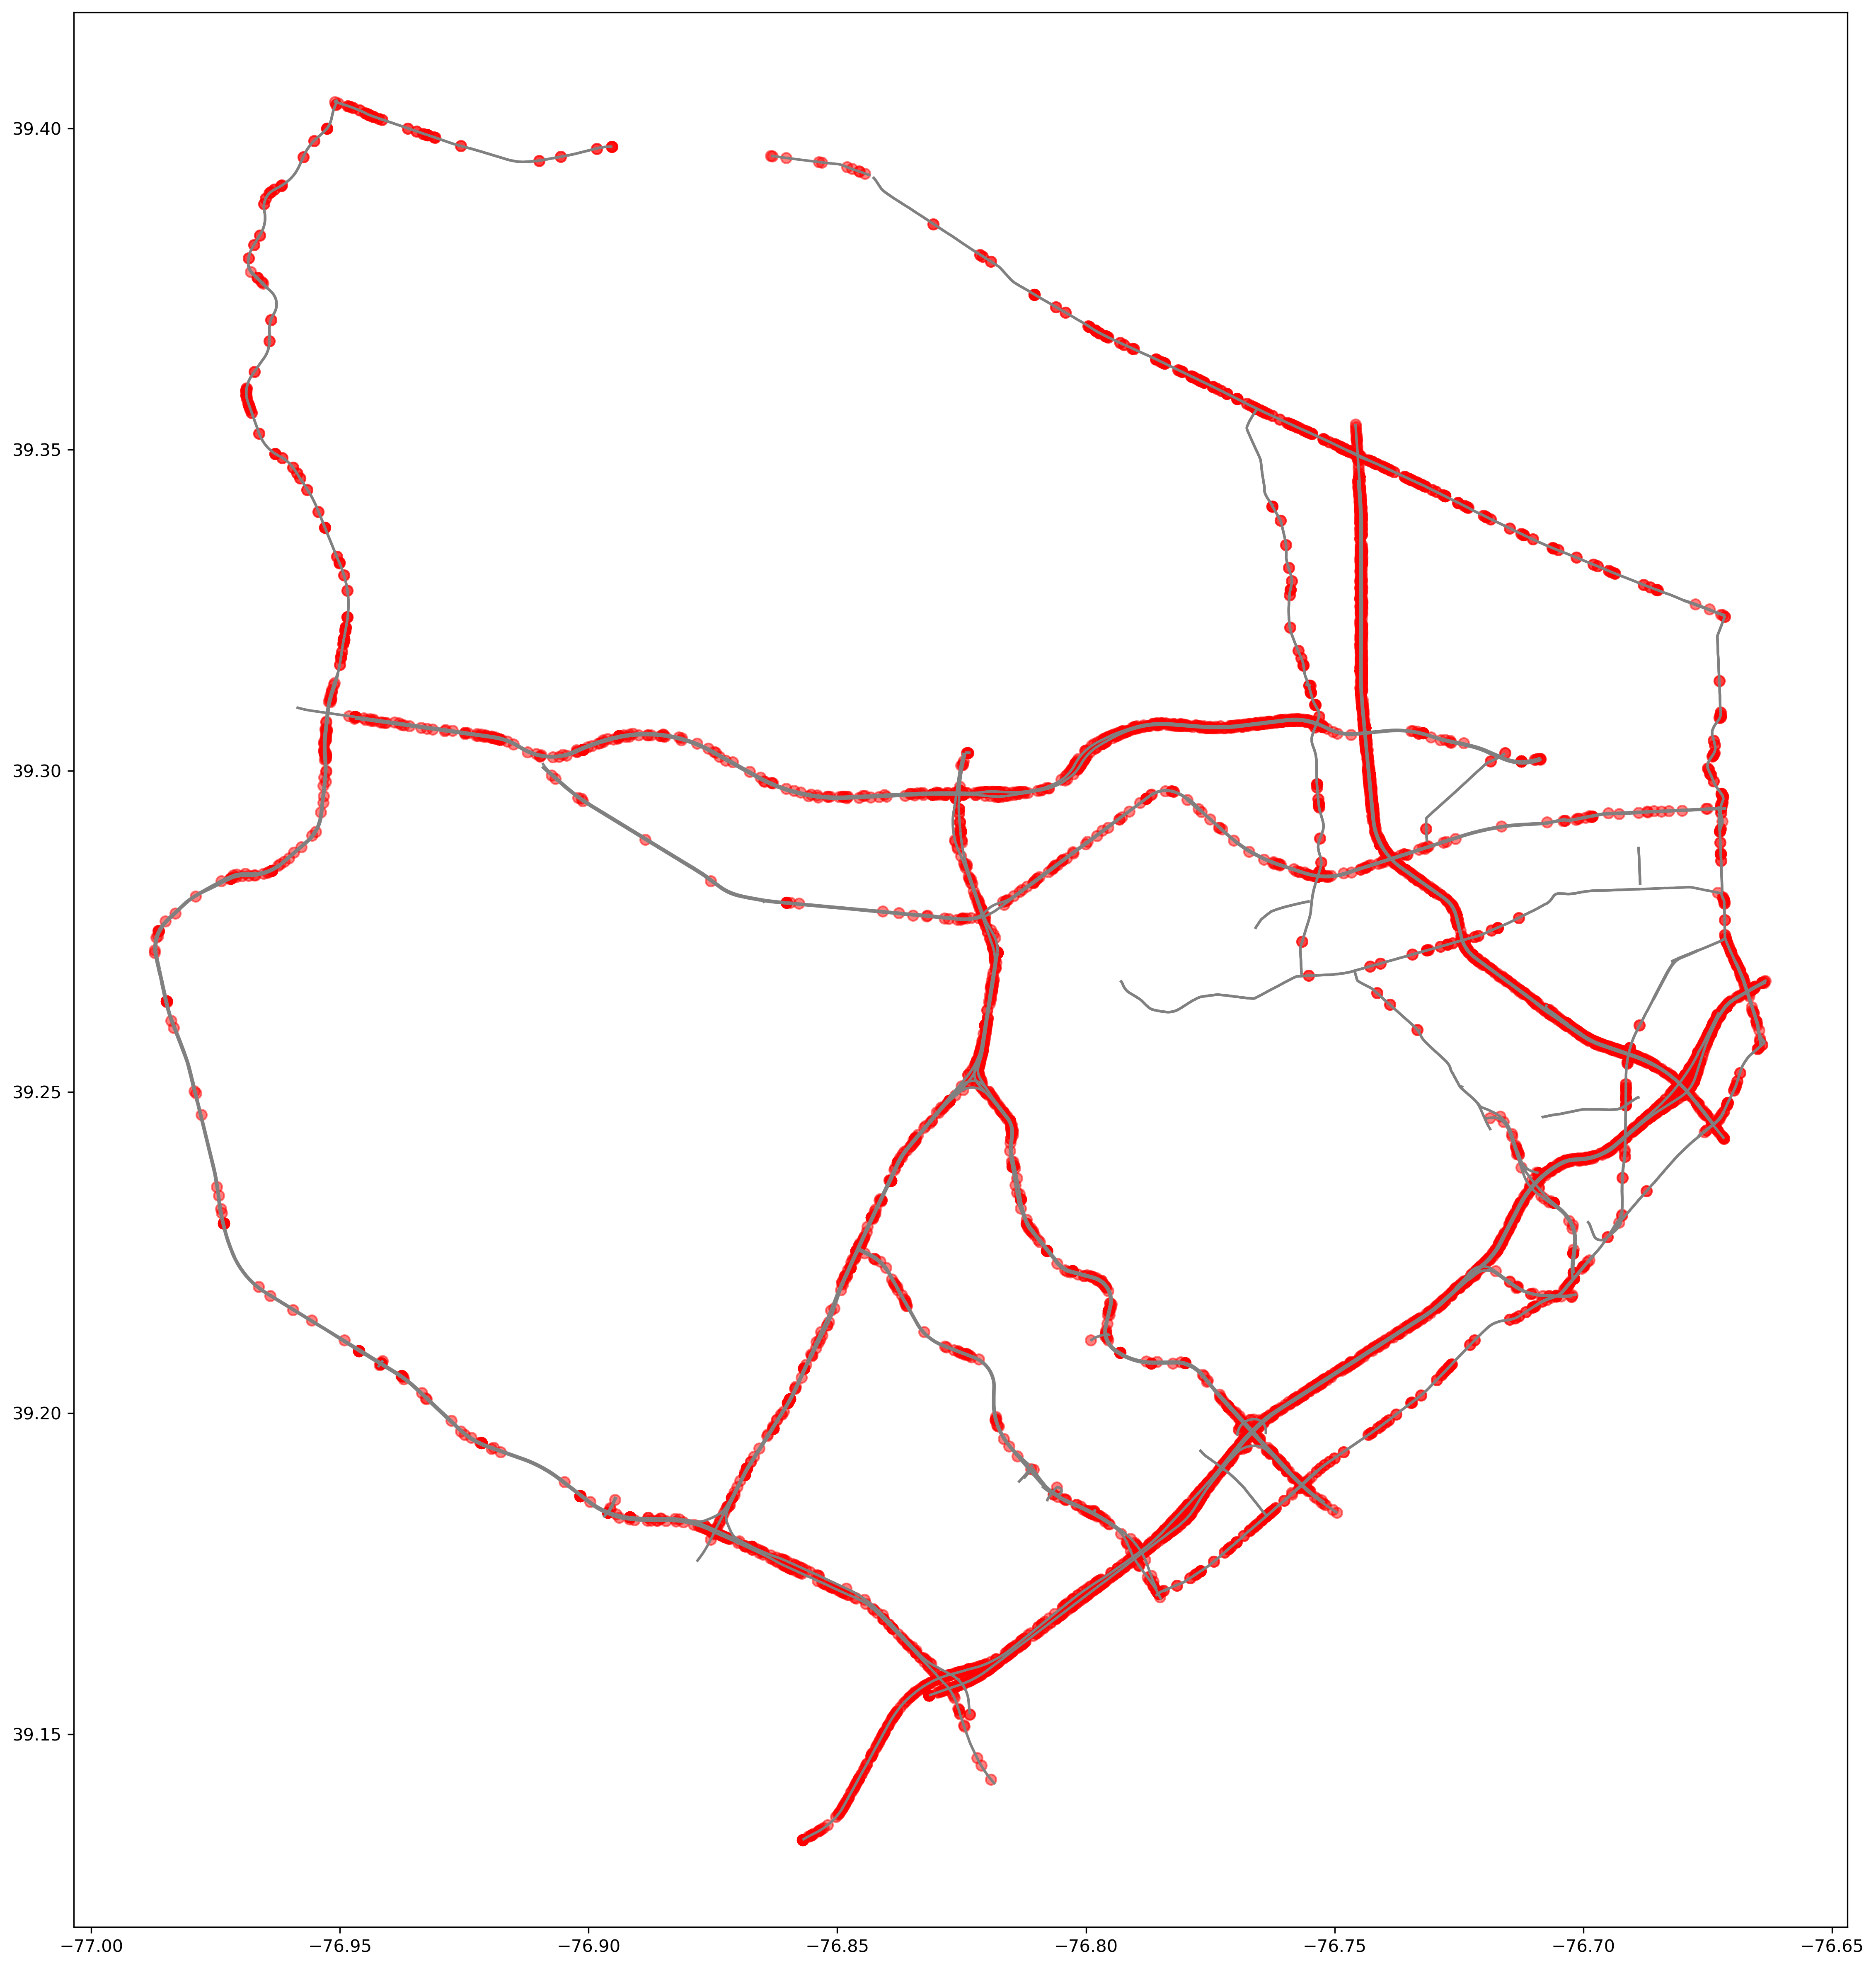

In [56]:
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_tmc_selected.plot(ax=ax, color = "grey")
gdf_inc_record_all.plot(ax=ax, color="red", alpha = 0.5)

## 4.1 demo example

# 5. Calculate Selected Link Slowdown Speed
-only calculate speed of selected links, however, when calculating upstream speed, we will use include links not in the selcted links

## 5.1. Calculate Average Recurrent Slowdown Speed (Currently Not Used)

## 5.2 Function to Label Incidents
 -Function to Mark Incidents that contains Significant Large Slowdown Speed

In [59]:
def label_all_incident_contain_significant_sd(raw_inc_list = list, sign_sd_list = list, day_number = int):
    day_list_length = int(len(raw_inc_list)/day_number)
    matched_incident_list = []
    for day_index in range(day_number):
        day_raw_inc_list = raw_inc_list[day_index*day_list_length:(day_index+1)*day_list_length]
        day_sign_sd_list = sign_sd_list[day_index*day_list_length:(day_index+1)*day_list_length]
        sum_list = [x + y for x, y in zip(day_raw_inc_list, day_sign_sd_list)]
        overlap_list = [1 if value==2 else 0 for value in sum_list]
        overlap_index = [index for index, value in enumerate(sum_list) if value == 2]
        for index in overlap_index:
            i = 1
            while (index-i)>=0:
                if day_raw_inc_list[index-i]==1:
                    overlap_list[index-i]=1
                    i+=1
                else:
                    break
            j = 1
            while (index+j)<day_list_length:
                if day_raw_inc_list[index+j]==1:
                    overlap_list[index+j]=1
                    j+=1
                else:
                    break
        matched_incident_list.extend(overlap_list)
    return matched_incident_list

In [57]:
# demo example
label_all_incident_contain_significant_sd([1, 1, 0, 1, 0, 0, 1, 1, 1], [1, 0, 0, 0, 1, 0, 0, 1, 0], 1)

[1, 1, 0, 0, 0, 0, 1, 1, 1]

 -Function to Label Long-lasting Significant Lagre Slowdown Speed as Incident

In [60]:
def label_long_last_abnormal_sd_as_incident(sign_sd_list = list, minimum_length = int, day_number = int):
    day_list_length = int(len(sign_sd_list)/day_number)
    labelled_incident_list = []
    for day_index in range(day_number):
        day_sign_sd_list = sign_sd_list[day_index*day_list_length:(day_index+1)*day_list_length]
        
        day_label_as_inc_list = [0]*len(day_sign_sd_list)
        count_number = 0
        for time_index in range(len(day_sign_sd_list)):
            if day_sign_sd_list[time_index] == 1:
                count_number +=1
                if count_number >= minimum_length:
                    for index in range(time_index - count_number+1, time_index+1):
                        day_label_as_inc_list[index] = 1
            else:
                count_number = 0
        labelled_incident_list.extend(day_label_as_inc_list)
    return labelled_incident_list

# 6. Label All Selected Incidents

In [61]:
df_slowdown_indicator = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)
df_sum_inc_and_slowdown_indicator = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)
df_inc_contain_abnormal_sd = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)
df_long_last_abnormal_sd = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)
df_final_selected_inc = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)

In [62]:
# should run for each link
def Label_and_Output_Link_Info(link_id, perentile_threshold, abnormal_sd_length_threshold):
    print('For TMC link',link_id,', There are', round((df_inc[link_id ] == 1).sum()/len(df_inc[link_id].index), 6)*100,'% labelled as incident by Waze')
    df_slowdown_indicator[link_id] = (df_slowdown_speed[link_id] >= df_slowdown_speed[link_id].quantile(perentile_threshold)).astype(int)
    df_sum_inc_and_slowdown_indicator = df_inc + df_slowdown_indicator
    inc_in_top_sd_percentile_ratio = round((df_sum_inc_and_slowdown_indicator[link_id] == 2).sum()/(df_slowdown_indicator[link_id] == 1).sum()*100, 2)
    selected_inc_in_raw_inc_ratio = round((df_sum_inc_and_slowdown_indicator[link_id] == 2).sum()/(df_inc[link_id] == 1).sum()*100, 2)
    conncted_inc_list = label_all_incident_contain_significant_sd(list(df_inc[link_id]), list(df_slowdown_indicator[link_id]), len(busi_date))
    all_connected_ratio = round(sum(conncted_inc_list)/(df_inc[link_id] == 1).sum()*100, 2)
    print('For TMC link',link_id,', in top', (round((1-perentile_threshold)*100, 4)), '% slowdown speed points, there are', inc_in_top_sd_percentile_ratio, '% points that are labelled as Incident by Waze, making up', selected_inc_in_raw_inc_ratio,'% in raw Waze incidents points')
    print('-If we link those points together, there will be',all_connected_ratio, '% raw Incident points relates to abnormal slowdown speed')
    print('________abnormal_slowdown_speed________')
    df_inc_contain_abnormal_sd[link_id] = conncted_inc_list 
    df_long_last_abnormal_sd[link_id] = label_long_last_abnormal_sd_as_incident(list(df_slowdown_indicator[link_id]), abnormal_sd_length_threshold, len(busi_date))
    abnormal_ls_sd_raw_waze_ratio = round(sum(df_long_last_abnormal_sd[link_id] == 1)/(df_inc[link_id] == 1).sum(), 4)
    df_final_selected_inc[link_id] = df_long_last_abnormal_sd[link_id] | df_inc_contain_abnormal_sd[link_id]
    abnormal_sd_increase_ratio = round(((df_final_selected_inc[link_id] == 1).sum()/(df_inc_contain_abnormal_sd[link_id] == 1).sum())*100, 4)
    print('-If we consider long-last abnormal sd as incident, compared to raw incident points, the ratio is', abnormal_ls_sd_raw_waze_ratio)
    print('-they increased final selected inc by', abnormal_sd_increase_ratio , '%')
    print('-finally, there are', round((df_final_selected_inc[link_id]== 1).sum()/len(df_inc[link_id].index), 6)*100,'% labelled as incident by us')
    return None

In [63]:
df_slowdown_indicator_train = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)
# should run for each link
def Label_and_Output_Link_Info_(link_id, perentile_threshold, train_perentile_threshold, abnormal_sd_length_threshold):
    print('_________Training Set>>>>>>>')
    frame_length = len(df_inc.index)
    cutoff = int(frame_length*0.7)
    print('For TMC link',link_id,', In the trianing set, There are', round((df_inc[link_id].iloc[:cutoff] == 1).sum()/cutoff, 6)*100,'% labelled as incident by Waze')
    df_slowdown_indicator_train[link_id] = (df_slowdown_speed[link_id] >= df_slowdown_speed[link_id].iloc[:cutoff].quantile(train_perentile_threshold)).astype(int)
    df_sum_inc_and_slowdown_indicator_train = df_inc + df_slowdown_indicator_train
    print('train', df_slowdown_speed[link_id].iloc[:cutoff].quantile(train_perentile_threshold), df_slowdown_speed[link_id].quantile(perentile_threshold))
    inc_in_top_sd_percentile_ratio_train = round((df_sum_inc_and_slowdown_indicator_train[link_id].iloc[:cutoff] == 2).sum()/(df_slowdown_indicator_train[link_id].iloc[:cutoff] == 1).sum()*100, 2)
    selected_inc_in_raw_inc_ratio_train = round((df_sum_inc_and_slowdown_indicator_train[link_id].iloc[:cutoff] == 2).sum()/(df_inc[link_id].iloc[:cutoff] == 1).sum()*100, 2)
    conncted_inc_list_train = label_all_incident_contain_significant_sd(list(df_inc[link_id].iloc[:cutoff]), list(df_slowdown_indicator[link_id].iloc[:cutoff]), int(len(busi_date)*0.7))
    all_connected_ratio_train = round(sum(conncted_inc_list_train)/(df_inc[link_id].iloc[:cutoff] == 1).sum()*100, 2)
    print('For TMC link',link_id,', in top', (round((1-train_perentile_threshold)*100, 4)), '% slowdown speed points, there are', inc_in_top_sd_percentile_ratio_train, '% points that are labelled as Incident by Waze, making up', selected_inc_in_raw_inc_ratio_train,'% in raw Waze incidents points')
    print('-If we link those points together, there will be',all_connected_ratio_train, '% raw Incident points relates to abnormal slowdown speed')
    print('<<<<<<<<Training Set_________')
    print('For TMC link',link_id,', There are', round((df_inc[link_id ] == 1).sum()/len(df_inc[link_id].index), 6)*100,'% labelled as incident by Waze')
    df_slowdown_indicator[link_id] = (df_slowdown_speed[link_id] >= df_slowdown_speed[link_id].quantile(perentile_threshold)).astype(int)
    df_sum_inc_and_slowdown_indicator = df_inc + df_slowdown_indicator
    inc_in_top_sd_percentile_ratio = round((df_sum_inc_and_slowdown_indicator[link_id] == 2).sum()/(df_slowdown_indicator[link_id] == 1).sum()*100, 2)
    selected_inc_in_raw_inc_ratio = round((df_sum_inc_and_slowdown_indicator[link_id] == 2).sum()/(df_inc[link_id] == 1).sum()*100, 2)
    conncted_inc_list = label_all_incident_contain_significant_sd(list(df_inc[link_id]), list(df_slowdown_indicator[link_id]), len(busi_date))
    all_connected_ratio = round(sum(conncted_inc_list)/(df_inc[link_id] == 1).sum()*100, 2)
    print('For TMC link',link_id,', in top', (round((1-perentile_threshold)*100, 4)), '% slowdown speed points, there are', inc_in_top_sd_percentile_ratio, '% points that are labelled as Incident by Waze, making up', selected_inc_in_raw_inc_ratio,'% in raw Waze incidents points')
    print('-If we link those points together, there will be',all_connected_ratio, '% raw Incident points relates to abnormal slowdown speed')
    

    print('________abnormal_slowdown_speed________')
    df_inc_contain_abnormal_sd[link_id] = conncted_inc_list 
    df_long_last_abnormal_sd[link_id] = label_long_last_abnormal_sd_as_incident(list(df_slowdown_indicator[link_id]), abnormal_sd_length_threshold, len(busi_date))
    abnormal_ls_sd_raw_waze_ratio = round(sum(df_long_last_abnormal_sd[link_id] == 1)/(df_inc[link_id] == 1).sum(), 4)
    df_final_selected_inc[link_id] = df_long_last_abnormal_sd[link_id] | df_inc_contain_abnormal_sd[link_id]
    abnormal_sd_increase_ratio = round(((df_final_selected_inc[link_id] == 1).sum()/(df_inc_contain_abnormal_sd[link_id] == 1).sum())*100, 4)
    print('-If we consider long-last abnormal sd as incident, compared to raw incident points, the ratio is', abnormal_ls_sd_raw_waze_ratio)
    print('-they increased final selected inc by', abnormal_sd_increase_ratio , '%')
    print('-finally, there are', round((df_final_selected_inc[link_id]== 1).sum()/len(df_inc[link_id].index), 6)*100,'% labelled as incident by us')
    return None

# I-70 Eastbound

In [67]:
Label_and_Output_Link_Info('110-04482', 0.95, minimum_abnormal_sd_length)

For TMC link 110-04482 , There are 3.2341 % labelled as incident by Waze
For TMC link 110-04482 , in top 5.0 % slowdown speed points, there are 15.34 % points that are labelled as Incident by Waze, making up 23.72 % in raw Waze incidents points
-If we link those points together, there will be 60.23 % raw Incident points relates to abnormal slowdown speed
________abnormal_slowdown_speed________
-If we consider long-last abnormal sd as incident, compared to raw incident points, the ratio is 1.3753
-they increased final selected inc by 292.6752 %
-finally, there are 5.701 % labelled as incident by us


# I-70 Westbound

In [71]:
Label_and_Output_Link_Info('110+04483', 0.97, minimum_abnormal_sd_length)

For TMC link 110+04483 , There are 1.2696 % labelled as incident by Waze
For TMC link 110+04483 , in top 3.0 % slowdown speed points, there are 9.99 % points that are labelled as Incident by Waze, making up 23.62 % in raw Waze incidents points
-If we link those points together, there will be 60.42 % raw Incident points relates to abnormal slowdown speed
________abnormal_slowdown_speed________
-If we consider long-last abnormal sd as incident, compared to raw incident points, the ratio is 2.0326
-they increased final selected inc by 399.7305 %
-finally, there are 3.0665999999999998 % labelled as incident by us


# 7. save selected Incident dataframe

In [153]:
pickle.dump(df_final_selected_inc, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_selected_incident.pkl", "wb"))

# 8. ahead labelling

In [154]:
def single_day_ahead_label(df, n):
    for col in df.columns:
        is_one = False
        start_index = 0
        for i in range(len(df)):
            if df[col].iloc[i] == 1 and not is_one:
                is_one = True
                start_index = max(0, i - n)
            elif df[col].iloc[i] == 0 and is_one:
                df[col].iloc[start_index:i] = 1
                is_one = False
        if is_one:
            df[col].iloc[start_index:] = 1
    return df

def all_day_ahead_label(df, day_number, ahead_number):
    m = int(df.shape[0]/day_number)
    result_df = pd.DataFrame()
    for start in tqdm(range(0, len(df), m)):
        end = min(start + m, len(df))
        df_subset = df.iloc[start:end].copy()
        df_subset = single_day_ahead_label(df_subset, ahead_number)
        result_df = pd.concat([result_df, df_subset], ignore_index=True)
    return result_df

In [156]:
df_final_selected_inc_ahead_15 = all_day_ahead_label(df_final_selected_inc, len(busi_date), 3)

100%|██████████| 260/260 [18:08<00:00,  4.19s/it]


In [158]:
pickle.dump(df_final_selected_inc_ahead_15, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_selected_incident_ahead_15.pkl", "wb"))